# House Prices Group 5 
# (Aleksandar, Arthur, Cyrill, Selina)

## Load packages

In [950]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.size'] = 10

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler 
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Function for Printing and Showing Confusion Matrix

In [ ]:
def print_results_crossvalidation(func, X_test, y_test):
  
  std_best_score = func.cv_results_["std_test_score"][func.best_index_]
  print(f"Best parameters: {func.best_params_}")
  print(f"Mean CV score: {func.best_score_:}")
  print(f"Standard deviation of CV score: {std_best_score:}")
  print("Test Score:".format(func.score(X_test, y_test)))

def report(y_true, y_pred):
    
  class_report = metrics.classification_report(y_true, y_pred)
  print(class_report)
  conf_matrix = confusion_matrix(y_true, y_pred, normalize = "all")
  conf_matrix = pd.DataFrame(conf_matrix, ["Class 0", "Class 1", " Class 2", "Class 3", " Class 4"],  ["Class 0", "Class 1", " Class 2", "Class 3", " Class 4"])
  sns.heatmap(conf_matrix, annot = True).set(xlabel = "Assigned Class", ylabel = "True Class", title = "Confusion Matrix")
     


## Load data and initial EDA

In [951]:
# Load data
df = pd.read_csv("GroupProjectDataSet.csv", sep=',')
print('Shape of data frame:', df.shape)
df.head(10)

Shape of data frame: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Class
0,530.0,20.0,RL,NaN,32668.0,Pave,NaN,IR1,Lvl,AllPub,...,0.0,NaN,NaN,NaN,0.0,3.0,2007.0,WD,Alloca,2.0
1,492.0,50.0,RL,79.0,9490.0,Pave,NaN,Reg,Lvl,AllPub,...,0.0,NaN,MnPrv,NaN,0.0,8.0,2006.0,WD,Normal,1.0
2,460.0,50.0,RL,NaN,7015.0,Pave,NaN,IR1,Bnk,AllPub,...,0.0,NaN,NaN,NaN,0.0,7.0,2009.0,WD,Normal,1.0
3,280.0,60.0,RL,83.0,10005.0,Pave,NaN,Reg,Lvl,AllPub,...,0.0,NaN,NaN,NaN,0.0,3.0,2008.0,WD,Normal,1.0
4,656.0,160.0,RM,21.0,1680.0,Pave,NaN,Reg,Lvl,AllPub,...,0.0,NaN,NaN,NaN,0.0,3.0,2010.0,WD,Family,0.0
5,1014.0,30.0,RM,60.0,7200.0,Pave,NaN,Reg,Lvl,AllPub,...,0.0,NaN,NaN,NaN,0.0,6.0,2009.0,WD,Normal,0.0
6,1404.0,20.0,RL,49.0,15256.0,Pave,NaN,IR1,Lvl,AllPub,...,0.0,NaN,NaN,NaN,0.0,8.0,2007.0,WD,Normal,2.0
7,602.0,50.0,RM,50.0,9000.0,Pave,NaN,Reg,Bnk,AllPub,...,0.0,NaN,NaN,NaN,0.0,12.0,2007.0,WD,Normal,1.0
8,1183.0,60.0,RL,160.0,15623.0,Pave,NaN,IR1,Lvl,AllPub,...,555.0,Ex,MnPrv,NaN,0.0,7.0,2007.0,WD,Abnorml,4.0
9,688.0,160.0,FV,NaN,5105.0,Pave,NaN,IR2,Lvl,AllPub,...,0.0,NaN,NaN,NaN,0.0,3.0,2007.0,WD,Normal,1.0


In [952]:
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,Class
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,1.306164
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,0.784595
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,0.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,1.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,1.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,2.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,4.000000


### Overview

The data set consists of 1460 observations with 81 variables (including the target variable "(prize) class" and the id variable). 79 variables are descriptive variables that should explain Class.

Quantitative: 1stFlrSF, 2ndFlrSF, 3SsnPorch, BedroomAbvGr, BsmtFinSF1, BsmtFinSF2, BsmtFullBath, BsmtHalfBath, BsmtUnfSF, EnclosedPorch, Fireplaces, FullBath, GarageArea, GarageCars, GarageYrBlt, GrLivArea, HalfBath, KitchenAbvGr, LotArea, LotFrontage, LowQualFinSF, MSSubClass, MasVnrArea, MiscVal, MoSold, OpenPorchSF, OverallCond, OverallQual, PoolArea, ScreenPorch, TotRmsAbvGrd, TotalBsmtSF, WoodDeckSF, YearBuilt, YearRemodAdd, YrSold

Qualitative: Alley, BldgType, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, BsmtQual, CentralAir, Condition1, Condition2, Electrical, ExterCond, ExterQual, Exterior1st, Exterior2nd, Fence, FireplaceQu, Foundation, Functional, GarageCond, GarageFinish, GarageQual, GarageType, Heating, HeatingQC, HouseStyle, KitchenQual, LandContour, LandSlope, LotConfig, LotShape, MSZoning, MasVnrType, MiscFeature, Neighborhood, PavedDrive, PoolQC, RoofMatl, RoofStyle, SaleCondition, SaleType, Street, Utilities

## Handling Missing Data

<AxesSubplot:>

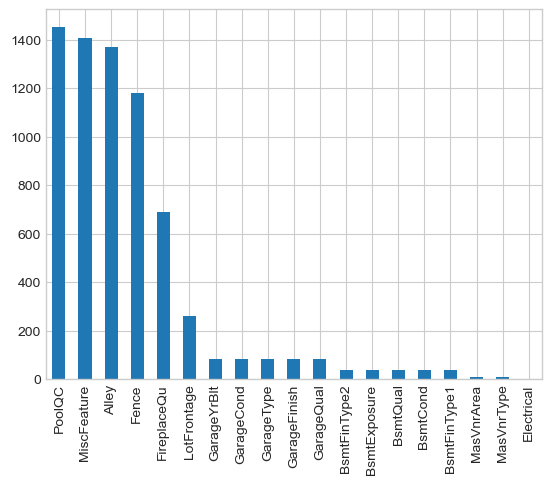

In [953]:
# Plot missing values

missing = df.isnull().sum().sort_values(ascending=False)
missing = missing[missing > 0]
missing.plot.bar()

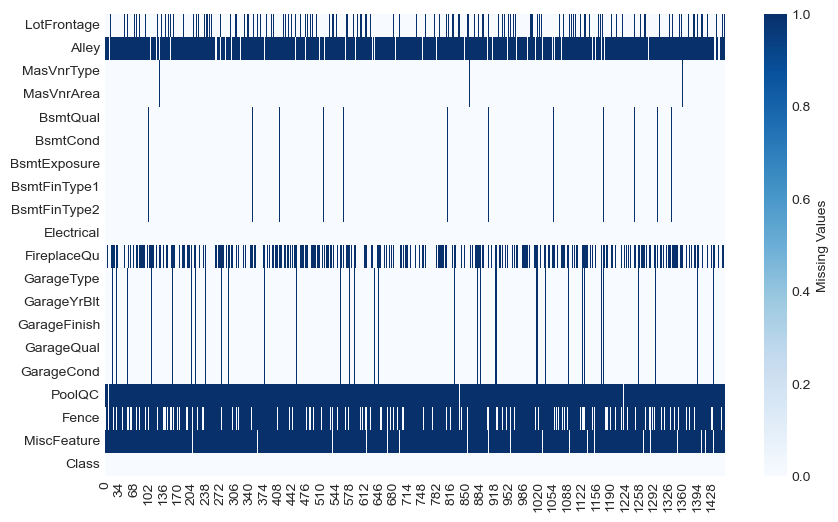

In [954]:
cols = df.columns[df.isna().any()]
df_nan = df[cols].copy()
df_nan['Class'] = df['Class']
df_nan.isna().sum() / df_nan.shape[0]

# Plot missing values 2.0
plt.figure(figsize=(10, 6))
sns.heatmap(df_nan.isna().transpose(),
            cmap="Blues",
            cbar_kws={'label': 'Missing Values'});

In [955]:
# Percentage of missing values for the variables

percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([missing, percent], axis=1, keys=['Nr. of missing values', 'Share'])
missing_data.head(20)

,Nr. of missing values,Share
PoolQC,1453.0,0.995205
MiscFeature,1406.0,0.963014
Alley,1369.0,0.937671
Fence,1179.0,0.807534
FireplaceQu,690.0,0.472603
LotFrontage,259.0,0.177397
GarageYrBlt,81.0,0.055479
GarageCond,81.0,0.055479
GarageType,81.0,0.055479
GarageFinish,81.0,0.055479


19 variables have missing values. Of the 19 variables four (PoolQC, MiscFeature, Alley, Fence) have more than 50% missing data and one (FireplaceQu) with nearly 50% missing data. But often NA does not mean that there is no data available. Instead (especially for thecategorical variables) it means that the house is lacking this specific object. NA in the PoolQC variable means that there is no pool; NA in the Alley variable means that there is "no alley access". All the descriptions of which NA stand for non-available data and which stand for a missing trait can be found in the [data description](https://www.openml.org/search?type=data&sort=runs&id=42165&status=active).

The following variables have NAs that can be filled:

- PoolQC: Na = No Pool
- MiscFeature: Na = None
- Alley: NA = No alley access
- Fence: NA = No Fence
- FireplaceQu: NA = No Fireplace
- GarageCond: NA = No Garage
- GarageType: NA = No Garage
- GarageFinish: NA = No Garage
- GarageQual: NA = No Garage
- BsmtFinType2: NA = No Basement
- BsmtExposure: NA = No Basement
- BsmtQual: NA = No Basement
- BsmtCond: NA = No Basement
- BsmtFinType1: NA = No Basement


In [956]:
# Filling missing values for variables where appropriate

df["PoolQC"] = df["PoolQC"].fillna(value = "No")
df["MiscFeature"] = df["MiscFeature"].fillna(value = "No")
df["Alley"] = df["Alley"].fillna(value = "No")
df["Fence"] = df["Fence"].fillna(value = "No")
df["FireplaceQu"] = df["FireplaceQu"].fillna(value = "No")
df["GarageCond"] = df["GarageCond"].fillna(value = "No")
df["GarageType"] = df["GarageType"].fillna(value = "No")
df["GarageFinish"] = df["GarageFinish"].fillna(value = "No")
df["GarageQual"] = df["GarageQual"].fillna(value = "No")
df["BsmtFinType2"] = df["BsmtFinType2"].fillna(value = "No")
df["BsmtExposure"] = df["BsmtExposure"].fillna(value = "No")
df["BsmtQual"] = df["BsmtQual"].fillna(value = "No")
df["BsmtCond"] = df["BsmtCond"].fillna(value = "No")
df["BsmtFinType1"] = df["BsmtFinType1"].fillna(value = "No")


<AxesSubplot:>

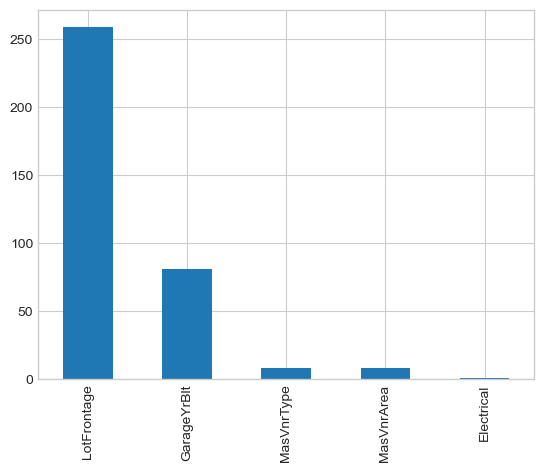

In [957]:
missing = df.isnull().sum().sort_values(ascending=False)
missing = missing[missing > 0]
missing.plot.bar()

In [958]:
# Percentage of missing values for the variables

percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([missing, percent], axis=1, keys=['Nr. of missing values', 'Share'])
missing_data.head(5)

,Nr. of missing values,Share
LotFrontage,259.0,0.177397
GarageYrBlt,81.0,0.055479
MasVnrType,8.0,0.005479
MasVnrArea,8.0,0.005479
Electrical,1.0,0.000685


For all but five variables we coud fill the missing data because with them NA indicates the lack of the corresponding trait. For LotFrontage we miss 17% of the values and 5.5% for GarageYrBlt. 

- LotFrontage ---> High Correlation with other variable?
- GarageYrBlt can probably be ignored since it highly correlates with YearBuilt. 
- MasVnrType and MasVnrArea have a strong correaltion with "YearBuilt" and "OverallQual" ---> Delete them?
- Electrical one missing value ---> Delete this observation or just leave it?



In [959]:
# further data cleaning
df = df.dropna(axis='columns', thresh=1459)
df = df.dropna(axis='rows', how = "any")

## Feature Engineering

### Dealing with Categorical Features (Encoding Categorical Variables) / Splitting Into X and y

In [963]:
# Numerical variables that should be handled as categorical variables
df = df.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"}})
df = df.replace({"MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}})

In [964]:
# we see that MoSold was succesfully changed
df.head(10)

,Id,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Class
0,530.0,SC20,RL,32668.0,Pave,No,IR1,Lvl,AllPub,CulDSac,...,0.0,No,No,No,0.0,Mar,2007.0,WD,Alloca,2.0
1,492.0,SC50,RL,9490.0,Pave,No,Reg,Lvl,AllPub,Inside,...,0.0,No,MnPrv,No,0.0,Aug,2006.0,WD,Normal,1.0
2,460.0,SC50,RL,7015.0,Pave,No,IR1,Bnk,AllPub,Corner,...,0.0,No,No,No,0.0,Jul,2009.0,WD,Normal,1.0
3,280.0,SC60,RL,10005.0,Pave,No,Reg,Lvl,AllPub,Inside,...,0.0,No,No,No,0.0,Mar,2008.0,WD,Normal,1.0
4,656.0,SC160,RM,1680.0,Pave,No,Reg,Lvl,AllPub,Inside,...,0.0,No,No,No,0.0,Mar,2010.0,WD,Family,0.0
5,1014.0,SC30,RM,7200.0,Pave,No,Reg,Lvl,AllPub,Inside,...,0.0,No,No,No,0.0,Jun,2009.0,WD,Normal,0.0
6,1404.0,SC20,RL,15256.0,Pave,No,IR1,Lvl,AllPub,CulDSac,...,0.0,No,No,No,0.0,Aug,2007.0,WD,Normal,2.0
7,602.0,SC50,RM,9000.0,Pave,No,Reg,Bnk,AllPub,Inside,...,0.0,No,No,No,0.0,Dec,2007.0,WD,Normal,1.0
8,1183.0,SC60,RL,15623.0,Pave,No,IR1,Lvl,AllPub,Corner,...,555.0,Ex,MnPrv,No,0.0,Jul,2007.0,WD,Abnorml,4.0
9,688.0,SC160,FV,5105.0,Pave,No,IR2,Lvl,AllPub,FR2,...,0.0,No,No,No,0.0,Mar,2007.0,WD,Normal,1.0


In [965]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 0 to 1459
Data columns (total 77 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   float64
 1   MSSubClass     1459 non-null   object 
 2   MSZoning       1459 non-null   object 
 3   LotArea        1459 non-null   float64
 4   Street         1459 non-null   object 
 5   Alley          1459 non-null   object 
 6   LotShape       1459 non-null   object 
 7   LandContour    1459 non-null   object 
 8   Utilities      1459 non-null   object 
 9   LotConfig      1459 non-null   object 
 10  LandSlope      1459 non-null   object 
 11  Neighborhood   1459 non-null   object 
 12  Condition1     1459 non-null   object 
 13  Condition2     1459 non-null   object 
 14  BldgType       1459 non-null   object 
 15  HouseStyle     1459 non-null   object 
 16  OverallQual    1459 non-null   float64
 17  OverallCond    1459 non-null   float64
 18  YearBuil

In [966]:
# Asign columns to feature matrix X and response vector y
X = df.iloc[:, 1:-1]
y = df.iloc[:, -1]

X.head(5)

,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,SC20,RL,32668.0,Pave,No,IR1,Lvl,AllPub,CulDSac,Gtl,...,0.0,0.0,No,No,No,0.0,Mar,2007.0,WD,Alloca
1,SC50,RL,9490.0,Pave,No,Reg,Lvl,AllPub,Inside,Gtl,...,0.0,0.0,No,MnPrv,No,0.0,Aug,2006.0,WD,Normal
2,SC50,RL,7015.0,Pave,No,IR1,Bnk,AllPub,Corner,Gtl,...,0.0,0.0,No,No,No,0.0,Jul,2009.0,WD,Normal
3,SC60,RL,10005.0,Pave,No,Reg,Lvl,AllPub,Inside,Gtl,...,0.0,0.0,No,No,No,0.0,Mar,2008.0,WD,Normal
4,SC160,RM,1680.0,Pave,No,Reg,Lvl,AllPub,Inside,Gtl,...,0.0,0.0,No,No,No,0.0,Mar,2010.0,WD,Family


In [967]:
y.head(5)

0    2.0
1    1.0
2    1.0
3    1.0
4    0.0
Name: Class, dtype: float64

In [968]:
X.shape

(1459, 75)

In [969]:
# factorise the binary variables (no need to create two dummy variables)
# ---> Problem of Multicollinearity 
#Without this the get_dummies would create two variables CentralAir_y and CentralAir_n
X["StreetFac"] = X.Street.factorize()[0]
X["CentralAirFac"] = X.CentralAir.factorize()[0]

In [970]:
# Factorize categorical values, assign output to X
# create (multiple) dummy variables for a categorical variable
# panda way

X = pd.get_dummies(X.iloc[:,:]) # not using ID
X.head()

,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,32668.0,6.0,3.0,1957.0,1975.0,1219.0,0.0,816.0,2035.0,2515.0,...,0,0,0,1,0,0,1,0,0,0
1,9490.0,6.0,7.0,1941.0,1950.0,403.0,165.0,238.0,806.0,958.0,...,0,0,0,1,0,0,0,0,1,0
2,7015.0,5.0,4.0,1950.0,1950.0,185.0,0.0,524.0,709.0,979.0,...,0,0,0,1,0,0,0,0,1,0
3,10005.0,7.0,5.0,1977.0,1977.0,392.0,0.0,768.0,1160.0,1156.0,...,0,0,0,1,0,0,0,0,1,0
4,1680.0,6.0,5.0,1971.0,1971.0,0.0,0.0,525.0,525.0,525.0,...,0,0,0,1,0,0,0,1,0,0


In [971]:
X.columns.values

array(['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'YrSold', 'StreetFac', 'CentralAirFac', 'MSSubClass_SC120',
       'MSSubClass_SC160', 'MSSubClass_SC180', 'MSSubClass_SC190',
       'MSSubClass_SC20', 'MSSubClass_SC30', 'MSSubClass_SC40',
       'MSSubClass_SC45', 'MSSubClass_SC50', 'MSSubClass_SC60',
       'MSSubClass_SC70', 'MSSubClass_SC75', 'MSSubClass_SC80',
       'MSSubClass_SC85', 'MSSubClass_SC90', 'MSZoning_C (all)',
       'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM',
       'Street_Grvl', 'Street_Pave', 'Alley_Grvl', 'Alley_No',
       '

### Partitioning of the Data Set Into Train and Test Set

We are using a 70/30 (training/testing) splitting. (The parameter `random_state=0` fixes the random split in a way such that results are reproducible.)

In [975]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42, 
                                                    stratify=y)

In [976]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1021 entries, 135 to 856
Columns: 321 entries, LotArea to SaleCondition_Partial
dtypes: float64(31), int64(2), uint8(288)
memory usage: 558.4 KB


## Handling Outliers

In [ ]:
out = IsolationForest(random_state = 42).fit(X_train)
out_train = out.predict(X_train)
out_test = out.predict(X_test)


X_train_wout_out = X_train[np.where(out_train == 1, True, False)]
y_train_wout_out = y_train[np.where(out_train == 1, True, False)]
X_test_wout_out = X_test[np.where(out_test == 1, True, False)]
y_test_wout_out = y_test[np.where(out_test == 1, True, False)]

print("Training Set")
print("Shape including outliers: ", X_train.shape)
print("Shape excluding outliers: ", X_train_wout_out.shape)
print("Nr. of outliers removed: ", X_train.shape[0]-X_train_wout_out.shape[0])

print(50*"-")

print("Test Set")
print("Shape including outliers: ", X_test.shape)
print("Shape excluding outliers: ", X_test_wout_out.shape)
print("Nr. of outliers removed: ", X_test.shape[0]-X_test_wout_out.shape[0]) 

In [1203]:
# Using the data without the outliers for the models

# Traning Set
X_train = X_train_wout_out
y_train = y_train_wout_out

# Test Set
X_test = X_test_wout_out
y_test = y_test_wout_out


### Feature Scaling

In [ ]:
# Get cols to scale
cols_scl = X.columns.values[:]

# Apply MinMaxScaler on continuous columns only
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train[cols_scl])  # fit & transform
X_test_norm  = mms.transform(X_test[cols_scl])  # ONLY transform

In [ ]:
# Apply StandardScaler on continuous columns only
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train[cols_scl])  # fit & transform
X_test_std  = stdsc.transform(X_test[cols_scl])  # ONLY transform

## Assessing Target Variable "Class"

** Assess Class imbalance. You make your own assessment on potential effects of class-imbalance. **

<AxesSubplot:title={'center':'Distribution of Class'}, xlabel='Class', ylabel='Count'>

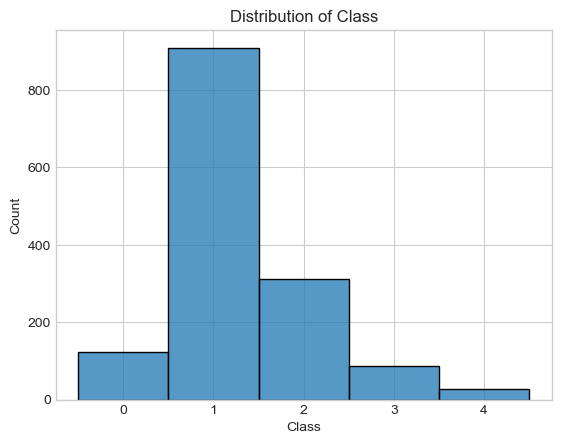

In [1208]:
plt.figure(1); plt.title('Distribution of Class')
sns.histplot(data=y, discrete = True)

We see that our "Class" deviates from the normal distribution, is positively skewed and shows peakedness (cortosis).

In [1210]:
#skewness and kurtosis
print("Skewness: %f" % df['Class'].skew())
print("Kurtosis: %f" % df['Class'].kurt())

Skewness: 1.099140
Kurtosis: 1.764907


# Decision Trees / Random Forest

## Decision Trees

In [1230]:
# Initializing decision tree
tree = DecisionTreeClassifier(max_depth=4, random_state = 42)
tree.fit(X_train, y_train)

# Performance metrics for training and test set
print('Train score: ', tree.score(X_train, y_train))
print('Test score: ', tree.score(X_test, y_test))

print(70*'-')

# Confusion matrix
y_pred = tree.predict(X_test)
print('Confusion matrix for Decision Tree: \n')
print("Left = Predicted; Top = Actual")
print(metrics.confusion_matrix(y_test, y_pred))

Train score:  0.8045409674234946
Test score:  0.7551487414187643
----------------------------------------------------------------------
Confusion matrix for Decision Tree: 

Left = Predicted; Top = Actual
[[  7  30   0   0   0]
 [  5 248  20   0   0]
 [  0  28  64   2   0]
 [  0   1  13   7   5]
 [  0   0   3   0   4]]


We see that 3 were predicted to be in class 4 but were actually in class 2. On was predicted to be in class 4 but was actually in class 1. 

### Visualizing Decision Tree
[Scikit-learn website for details.](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html).

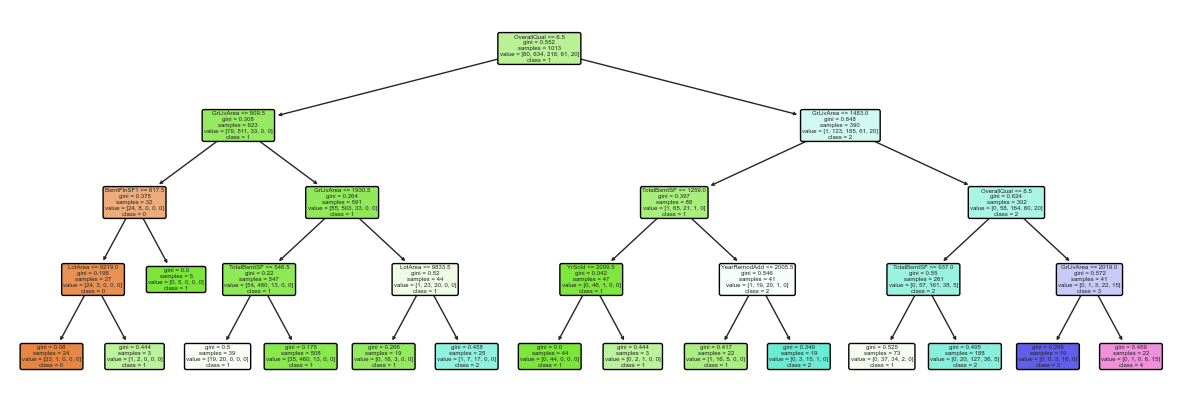

In [1213]:
# Plot tree
plt.figure(figsize=(15, 5))
plot_tree(tree, filled=True, feature_names = list(X.columns), rounded=True, class_names=["0", "1", "2", "3", "4"],);

### Grid Search (Finding Hyperparameters)
Evaluates the model performance for each combination of hyperparameter to obtain the optimal combination of values from this set (Raschka (2015)).

In [1214]:
# get a list of all possible parameters
print(f"Parameters of the Decision Tree: {tree.get_params().keys()}")

Parameters of the Decision Tree: dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])


In [1218]:
# k-Fold CV object (k = 5)
kFold = StratifiedKFold(n_splits=5)


####### Parameters of the Decision Tree under investigation #######

# In the initial tuning we included more values.
# But more values cause more computational effort.
# We only have a preselected list of values that include values around the best value.


##### Estimators #####

# Criterion
# The function to measure the quality of a split.
Criterion = np.array(["gini", "entropy"])

# Splitter 
# The strategy used to choose the split at each node.
Splitter = np.array(["best", "random"])

# Class weight
# Weights associated with classes in the form {class_label: weight}.
class_Weight = np.array([None, "balanced", "balanced_subsample"])

# Max depth
# The maximum depth of the tree. 
maxDepth = np.array([1, 5, 7, 8, 9, 10, 11, 12, 15, 18])

# Max features
# The number of features to consider when looking for the best split.
max_Features = np.array([None, "auto", "sqrt", "log2"])

# min_Samples_Split
# The minimum number of samples required to split an internal node.
min_Samples_Split = np.array([1, 2, 3, 4, 5])

# minSamplesLeaf
minSamplesLeaf = np.array([1, 2, 3, 4, 5])




In [1219]:
# hyperparameter to be tested
param_grid_tr = {"class_weight": class_Weight,
              "criterion": Criterion,
              "max_depth": maxDepth,
              "splitter": Splitter,
              "max_features": max_Features,
              "min_samples_split": min_Samples_Split,
              "min_samples_leaf": minSamplesLeaf,
}

# grid search
tree_gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                  param_grid=param_grid_tr,
                  scoring="accuracy",
                  cv=kFold, n_jobs=-1)
tree_gs = tree_gs.fit(X_train, y_train)
print("Best Score:")
print(tree_gs.best_score_)
print("Best Values for Hyperparameter:")
print(tree_gs.best_params_)

Best Score:
0.7789006486855582
Best Values for Hyperparameter:
{'class_weight': None, 'criterion': 'gini', 'max_depth': 9, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'splitter': 'best'}


In [1079]:
# Take best parameter
clf = tree_gs.best_estimator_

# Fitting the model with the best parameter
clf.fit(X_train, y_train)

# Print out score on Test dataset
print("Accuracy Test Set: {0: .4f}".format(clf.score(X_test, y_test)))

Test accuracy:  0.7763


## Random Forest

### Grid Search (Finding Hyperparameters)
Evaluates the model performance for each combination of hyperparameter to obtain the optimal combination of values from this set (Raschka (2015)).

In [1149]:
# Initializing Classifier object
forest = RandomForestClassifier(n_estimators = 100, criterion="gini", random_state=42, n_jobs=-1)

# Get a list of all parameters of random forest
print(f"Parameters of Random Forest: {forest.get_params().keys()}")

Parameters of Random Forest: dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])


In [1225]:
# k-Fold CV object (k = 5)
kFold = StratifiedKFold(n_splits=5)


####### Parameters for the Random Forest #######

# In the initial tuning we included more values.
# But more values cause more computational effort.
# We only have a preselected list of values that include values around the best value.


##### Estimators #####

# The number of trees in the forest.
n_Estimators = np.array([90, 95, 100, 105])

# Criterion
# The function to measure the quality of a split.
Criterion = np.array(["gini", "entropy"])

# Class weight
# Weights associated with classes in the form {class_label: weight}.
class_Weight = np.array([None, "balanced", "balanced_subsample"])

# Max depth
# The maximum depth of the tree. 
maxDepth = np.array([5, 10, 15, 20])

# Max features
# The number of features to consider when looking for the best split.
max_Features = np.array([None, "auto", "sqrt", "log2"])

# min_Samples_Split
# The minimum number of samples required to split an internal node.
min_Samples_Split = np.array([2, 3, 4])

# minSamplesLeaf
minSamplesLeaf = np.array([1, 2, 3])

# Bootstrap
BootStrap = np.array(["False", "True"])


In [1226]:
# hyperparameter to be tested (for computational reasons those where the default is the best are hashtaged)
param_grid_fo = {
              #"class_weight": class_Weight,
              "criterion": Criterion,
              "n_estimators": n_Estimators,
              "max_depth": maxDepth,
              "max_features": max_Features,
              "min_samples_split": min_Samples_Split,
              "min_samples_leaf": minSamplesLeaf,
              #"bootstrap": BootStrap
}

# grid search
forest_gs = GridSearchCV(estimator=RandomForestClassifier(random_state=0, n_jobs=-1),
                  param_grid=param_grid_fo,
                  scoring="accuracy",
                  cv=kFold, n_jobs=-1)
forest_gs = forest_gs.fit(X_train, y_train)
print("Best Score:")
print(forest_gs.best_score_)
print("Best Values for Hyperparameter:")
print(forest_gs.best_params_)


Best Score:
0.8144076476613178
Best Values for Hyperparameter:
{'class_weight': None}


In [1227]:
# Take best parameter
clf = forest_gs.best_estimator_

# Fitting the model with the best parameter
clf.fit(X_train, y_train)

# Print out score on Test dataset
print("Accuracy Test Set: {0: .4f}".format(clf.score(X_test, y_test)))

Accuracy Test Set:  0.8192
